# PyTorchDIA Tutorial

This tutorial demonstrates how to use the code and provides some tips for improving performance.

In [1]:
# imports
import PyTorchDIA
from MakeFakeImage import MakeFake
import torch
import numpy as np
from scipy.stats import norm
from astropy.io import fits
import matplotlib.pyplot as plt
%matplotlib inline

PyTorch version: 1.6.0
PyTorch version: 1.6.0


In [2]:
# for reproducibility, use deterministic CUDA convolution computations only
torch.backends.cudnn.deterministic = True

## 1) Basics

First, let's generate some artifical CCD data to work with. The data -- with per-pixel indices $ij$ -- are independently drawn from $\mathcal{N}(M, \sigma^2)$, where $M_{ij}$ is our image model. For the pixel variances, we adopt the 'standard' CCD noise model,

$\sigma^2 = \frac{\sigma_{0}^{2}}{F_{ij}^{2}} + \frac{M_{ij}}{G\;F_{ij}}$,

where $\sigma_0$ is the read noise (ADU), $G$ is the detector gain ($\textrm{e}^- / \textrm{ADU}$), and $F$ is the master flat field.

In [3]:
## Generate an artifical reference and target image pair

# set random seed
np.random.seed(42)

# generate noiseless reference 'ref'
print('Generating reference...')
size = 142
log_density = np.random.uniform(0, 3, 1)[0]
star_density = 10**log_density # stars per 100x100 pixels
n_sources = np.int(star_density * (size**2/100**2))       
phi_r = np.random.uniform(0.5, 2.5, 1)[0] # in pixels, this is ~ [1 - 6] fwhm
sky = np.random.uniform(10, 1000, 1)[0] # ADU 

# positions
positions_x = np.random.uniform(0, size, (n_sources,1))
positions_y = np.random.uniform(0, size, (n_sources,1))
positions = np.hstack((positions_x, positions_y))

# fluxes
F = np.random.uniform(10**(-9), 10**(-4.5), n_sources)
fluxes = F**(-2./3.)

# Generate the noiseless reference image
ref_noiseless, F_frac = MakeFake(N=1, size=size, n_sources=n_sources,
                                 psf_sigma=phi_r, sky=sky,
                                 positions=positions, fluxes=fluxes, shifts=[0, 0])

print('Reference properties')
print('Reference size:', size)
print('Number of sources:', n_sources)
print('PSF standard deviation:', phi_r)
print('Sky level:', sky)
print('F_max/F_total:', F_frac) # flux ratio of brightest star that of all stars

print('Target kernel properties:')
phi_k = np.random.uniform(0.5, 2.5, 1)[0]
kernel_size = 19
print('Kernel standard deviation:', phi_k)
print('Kernel size:', kernel_size)

# Generate the noiseless (and shifted) target image
phi_i = np.sqrt(phi_k**2 + phi_r**2)

# positions
shift_x = np.random.uniform(-0.5, 0.5, 1)
shift_y = np.random.uniform(-0.5, 0.5, 1)
#shift_x, shift_y = 0, 0
print('shift_x, shift_y:', shift_x, shift_y)
positions_x_shifted = positions_x + shift_x
positions_y_shifted = positions_y + shift_y
positions_shifted = np.hstack((positions_x_shifted, positions_y_shifted))

imag_noiseless, F_frac = MakeFake(N=1, size=size, n_sources=n_sources,
                                 psf_sigma=phi_i, sky=sky,
                                 positions=positions_shifted, fluxes=fluxes,
                                 shifts = [shift_x[0], shift_y[0]])    


imag_noiseless_copy = np.copy(imag_noiseless)
ref_noiseless_copy = np.copy(ref_noiseless)

# read noise [ADU]
sigma_0 = 5.

# add gaussian noise to image under the standard CCD noise model
# N.B. Gain and flat-field are equal to 1, so we only include
# the readout noise [ADU] and the photon shot noise (in the gaussian limit)
def add_noise_to_image(image, read_noise):
    noise_map = np.random.normal(0, 1, size=image.shape)
    sigma_imag = np.sqrt(read_noise**2 + image)
    image += noise_map*sigma_imag
    return image, sigma_imag

# adds 10 times **less** variance than add_noise_to_image
def add_less_noise_to_image(image, read_noise):
    noise_map = np.random.normal(0, 1, size=image.shape)
    sigma_imag = 10**(-0.5) * np.sqrt(read_noise**2 + image)
    image += noise_map*sigma_imag
    return image, sigma_imag

# add noise to the reference image
ref, sigma_ref = add_less_noise_to_image(image=ref_noiseless, read_noise=sigma_0)
ref_copy = np.copy(ref)

# add noise to the target image i.e.
imag, sigma_imag = add_noise_to_image(image=imag_noiseless, read_noise=sigma_0)

print('Reference and target image shapes:')
print(ref.shape, imag.shape)

Generating reference...
Max flux: 31887.373306543665
Frac for 142x142 image: 0.3336664210470882
Reference properties
Reference size: 142
Number of sources: 26
PSF standard deviation: 2.4014286128198323
Sky level: 734.6740023932911
F_max/F_total: 0.3336664210470882
Target kernel properties:
Kernel standard deviation: 1.7465962536551158
Kernel size: 19
shift_x, shift_y: [-0.16910198] [-0.43644165]
Max flux: 31887.373306543665
Frac for 142x142 image: 0.3336664210470882
Reference and target image shapes:
(142, 142) (142, 142)


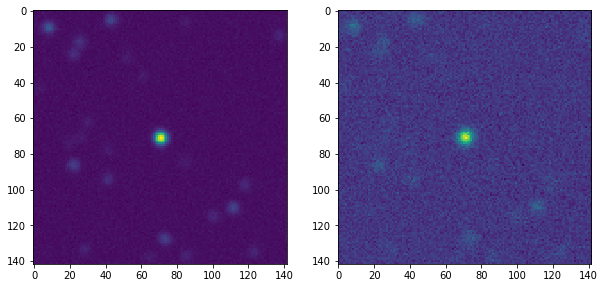

In [4]:
# plot
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
ax[0].imshow(ref)
ax[1].imshow(imag);

**Tip**: It is almost always a good idea to subtract some estimate of the sky from the reference image. This helps to break the strong anticorrelation between the parameters* in the DIA image model.

*Specifically, the photometric scale factor (sum of kernel pixels) and the differential background.

In [5]:
### sky subtract the reference image
ref -= sky

The user must provide the *scalar objective* function to optimise. For this CCD data, with Gaussian noise, we should use the following (negative) log-likelihood

$-\textrm{ln}\;\textrm{p}(I_{ij} | \boldsymbol{\theta}) = \frac{1}{2}\chi^2\ + \sum_{ij} \ln\;\sigma_{ij} + \frac{N_\mathrm{data}}{2} \textrm{ln}(2\mathrm{\pi})  \;,$

where $\sigma_{ij}$ are the pixel uncertainties, $N_{\mathrm{data}}$ is the number of pixels in the target image, and the $\chi^2$ is equal to

$\chi^2 = \sum_{ij}\left(\frac{I_{ij} - M_{ij}}{\sigma_{ij}} \right)^2 \;.$


$\boldsymbol{\theta}$ are the model parameters; the kernel pixels and differential background term(s). Let's write this in code (ignoring the irrelevant normalisation constant).

The only requirement for loss functions fed to PyTorchDIA is that the **first argument is the model**, and the **second agrument is the data**. If a flat field is available, this can be passed as an optional third agrument (seen further down). In this example, the flat field is assummed to be perfect, so we can just ignore it. We do have to pass some keyword agruments for the readout noise and detector gain though.

In [6]:
# gaussian negative log-likelihood
def gaussian_loss_fn(model, data, rdnoise=5, G=1):
    # guard against negative pixel-variances should they arise during the optimisation
    var = (torch.clamp(model, min=0.) / G) + rdnoise**2
    chi2 = torch.sum((model - data) ** 2 / var)
    ln_sigma = torch.sum(torch.log(var))
    nll = 0.5 * (chi2 + ln_sigma)
    return nll

OK, we're ready to fit a model image to our data image using PyTorchDIA. The simplest DIA model -- with just a scalar differential background term -- has the form

$M_{ij} = [R \otimes K]_{ij} + B_0$,

and can be fit as simply as follows...

Moving images to the GPU...
--- Time to move data onto GPU: 3.212078332901001 ---
Check dtype of data and weights:
torch.float32 torch.float32 torch.float32 torch.float32
Check size of data and weights:
torch.Size([1, 1, 142, 142]) torch.Size([1, 1, 124, 124]) torch.Size([1, 1, 19, 19]) torch.Size([1])
Starting optimisation
Switching to Quasi-Newton step after 418 SD steps
Converged!
Total steps taken: 423
SD steps: 418
L-BFGS steps: 5
--- Finished kernel and background fit in 5.351428985595703 seconds ---
Photometric scaling: 0.9372105598449707
B_0: 734.5671997070312


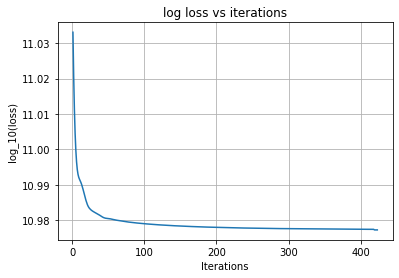

--- Finished in a total of 8.709760904312134 seconds ---


In [7]:
kernel_size = 19
res = PyTorchDIA_General.DIA(ref, # reference image (np.ndarray)
                    imag, # data image (np.ndarray)
                    gaussian_loss_fn, # loss function
                    ks = kernel_size, # (square) kernel size: ks x ks
                    show_convergence_plots = True) # plot loss vs iterations

The code outputs some diagnostic information about the optimisation e.g. number of steepest descent (SD) steps, L-BFGS steps and a plot of (log) loss vs iterations. And returns the kernel, the differential background term(s) and the model. Let's plot the image (and histogram) of normalised residuals to check all is well.

In [8]:
# these are returned as numpy.ndarrays (if multi-dimensional... B0 is a scalar)
kernel, B0, model = res

**Tip**: Convolutions are undefined within half a kernel's width of data image's border, so we need to trim this appropriately to match the size of the model.

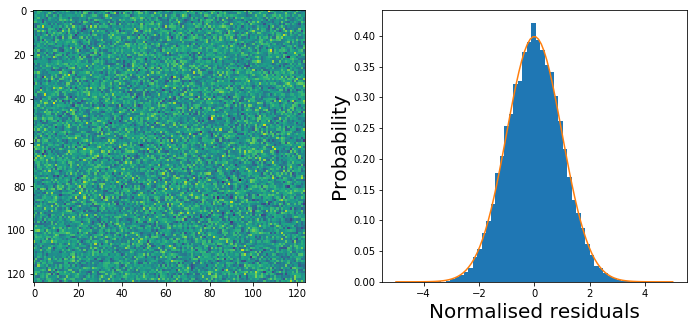

In [9]:
# trim I such that target image pixels correspond to only those with valid convolution computations
hwidth = np.int((kernel_size - 1) / 2)
nx, ny = imag.shape
trimmed_imag = imag[hwidth:nx-hwidth, hwidth:nx-hwidth]
residuals = trimmed_imag - model
sigma = np.sqrt(model + sigma_0**2)
normalised_residuals = residuals / sigma

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
x = np.linspace(-5, 5, 100)
ax[0].imshow(normalised_residuals)
ax[1].hist(normalised_residuals.flatten(), bins=50, density=True)
ax[1].plot(x, norm.pdf(x, 0, 1))
ax[1].set_xlabel('Normalised residuals', fontsize=20)
ax[1].set_ylabel('Probability', fontsize=20);

## 2) Modelling a spatially varying background

Let's repeat the above, but add a spatially varying sky background to our data image.

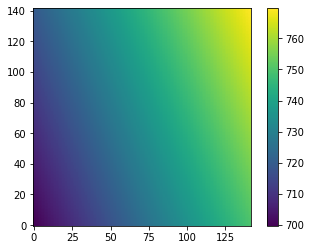

In [10]:
np.random.seed(42)
nx, ny = imag_noiseless_copy.shape
x = np.linspace(-0.5, 0.5, nx)
y = np.linspace(-0.5, 0.5, ny)
X, Y = np.meshgrid(x, y, copy=False)

## polynomial coefficients - drop back in the sky level as the 0th degree component
coeffs = [sky, 50, 20]

def spatially_varying_sky(X, Y, c):
    return c[0] + X*c[1] + Y*c[2]

# subtract off the scalar sky we added above
imag_noiseless = imag_noiseless_copy + spatially_varying_sky(X, Y, coeffs) - sky

# add noise to the target image i.e.
imag_var_bkg, sigma_imag = add_noise_to_image(image=imag_noiseless, read_noise=sigma_0)

# plot
plt.imshow(spatially_varying_sky(X, Y, coeffs), origin='lower')
plt.colorbar();

In [11]:
## remember to subtract some estiamte of the sky from the reference
ref = ref_copy - sky

Moving images to the GPU...
--- Time to move data onto GPU: 0.0005426406860351562 ---
Parameter containing:
tensor([[737.6130981445,   1.0000000000,   1.0000000000]], requires_grad=True)
Check dtype of data and weights:
Check dtype of data and weights:
torch.float32 torch.float32 torch.float32 torch.float32
Check size of data and weights:
torch.Size([1, 1, 142, 142]) torch.Size([1, 1, 124, 124]) torch.Size([1, 1, 19, 19]) torch.Size([1, 3])
Starting optimisation
Switching to Quasi-Newton step after 403 SD steps
Converged!
Total steps taken: 406
SD steps: 403
L-BFGS steps: 3
--- Finished kernel and background fit in 4.003419637680054 seconds ---
Photometric scaling: 0.9607652425765991
B coeffs: tensor([734.8317871094,  42.7868232727,  18.6998348236])


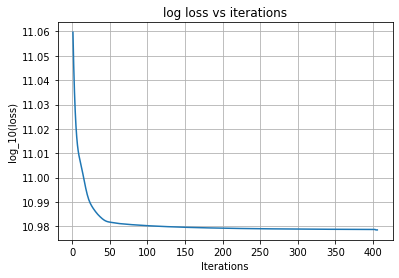

--- Finished in a total of 4.200392723083496 seconds ---


In [21]:
kernel_size = 19
res = PyTorchDIA_General.DIA(ref, # reference image (np.ndarray)
                    imag_var_bkg, # data image (np.ndarray)
                    gaussian_loss_fn, # loss function
                    ks = kernel_size, # (square) kernel size: ks x ks
                    poly_degree = 1, # polynomial degree for spatially varying background
                    show_convergence_plots = True) # plot loss vs iterations

In [22]:
kernel, B, model = res

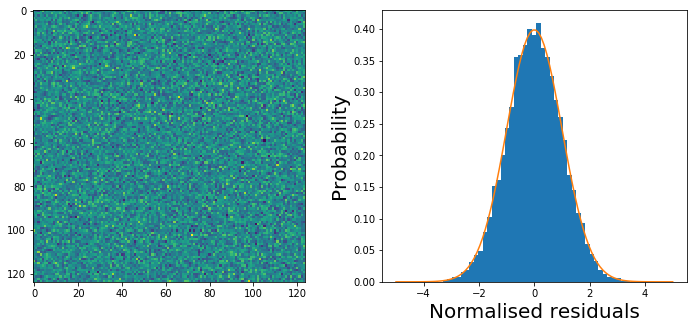

In [23]:
# trim I such that target image pixels correspond to only those with valid convolution computations
hwidth = np.int((kernel_size - 1) / 2)
nx, ny = imag_var_bkg.shape
trimmed_imag = imag_var_bkg[hwidth:nx-hwidth, hwidth:nx-hwidth]
residuals = trimmed_imag - model
sigma = np.sqrt(model + sigma_0**2)
normalised_residuals = residuals / sigma

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
x = np.linspace(-5, 5, 100)
ax[0].imshow(normalised_residuals)
ax[1].hist(normalised_residuals.flatten(), bins=50, density=True)
ax[1].plot(x, norm.pdf(x, 0, 1))
ax[1].set_xlabel('Normalised residuals', fontsize=20)
ax[1].set_ylabel('Probability', fontsize=20);

## 3) Going beyond Gaussian noise models

Real images have outliers, not captured by our simple Gaussian noise model. Indeed, these are usually the things we're interested in further downstream. To ensure the fit is robust to these sources, we can use *robust* loss functions.

In [2]:
## load the reference, data and master flat images
ref_emccd = fits.getdata('coll_LOB190560Z_Llr_2019-05-14_00129.fits')
data_emccd = fits.getdata('coll_LOB190560Z_Llr_2019-05-10_00107.fits')
flat_emccd = fits.getdata('master_flat.fits')

In [3]:
# as c -> infinity, this loss function is identical to the Gaussian
# loss we used previously. c = 1.345 is generally recommended.
def robust_loss_fn(model, data, flat, f=25.8, G_EM=300, c=1.345):
    
    # Total gain, G, and EMCCD excess noise factor, E
    G = f / G_EM
    E = 2

    shot_noise = torch.clamp(model, min=0.)/(G*flat)
    var = E*shot_noise

    sigma = torch.sqrt(var)
    ln_sigma = torch.sum(torch.log(sigma))

    # gaussian when (model - targ)/NM <= c
    # absolute deviation when (model - targ)/NM > c
    cond1 = torch.abs((model - data)/sigma) <= c
    cond2 = torch.abs((model - data)/sigma) > c
    inliers = ((model - data)/sigma)[cond1]
    outliers = ((model - data)/sigma)[cond2]

    l2 = 0.5*torch.sum(torch.pow(inliers, 2))
    l1 = (c * torch.sum(torch.abs(outliers)) - (0.5 * c**2))

    nll = l2 + l1 + ln_sigma

    return nll

In [4]:
## again, remember to subtract some estimate of the sky from the background
ref_emccd -= np.median(ref_emccd)

In [5]:
kernel_size = 31
res = PyTorchDIA_General.DIA(ref_emccd, # reference image (np.ndarray)
                             data_emccd, # data image (np.ndarray)
                             robust_loss_fn, # loss function
                             flat_emccd, # flat (np.ndarray)
                             ks = kernel_size, # (square) kernel size: ks x ks
                             show_convergence_plots = True) # plot loss vs iterations

Moving images to the GPU...
--- Time to move data onto GPU: 3.376096487045288 ---
Check dtype of data and weights:
torch.float32 torch.float32 torch.float32 torch.float32
Check size of data and weights:
torch.Size([1, 1, 512, 512]) torch.Size([1, 1, 482, 482]) torch.Size([1, 1, 31, 31]) torch.Size([1])
Starting optimisation
Switching to Quasi-Newton step after 164 SD steps


KeyboardInterrupt: 

In [ ]:
kernel, B, model = res

In [ ]:
# trim I such that target image pixels correspond to only those with valid convolution computations
hwidth = np.int((kernel_size - 1) / 2)
nx, ny = data_emccd.shape
trimmed_imag = data_emccd[hwidth:nx-hwidth, hwidth:nx-hwidth]
trimmed_flat = flat_emccd[hwidth:nx-hwidth, hwidth:nx-hwidth]
residuals = trimmed_imag - model

# Total gain, G, and EMCCD excess noise factor, E
G = 25.8 / 300
E = 2
shot_noise = model/(G*trimmed_flat)
sigma = np.sqrt(E*shot_noise)
                    
# normalised residuals                    
normalised_residuals = residuals / sigma

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
x = np.linspace(-5, 5, 100)
ax[0].imshow(normalised_residuals)
ax[1].hist(normalised_residuals.flatten(), bins=100, density=True)
ax[1].plot(x, norm.pdf(x, 0, 1))
ax[1].set_xlabel('Normalised residuals', fontsize=20)
ax[1].set_ylabel('Probability', fontsize=20)
ax[1].set_xlim(-5, 5);